In [1]:
import numpy as np
np.random.seed(42)

In [2]:
class Layer:
    
    #A building block. Each layer is capable of performing two things:    #- Process input to get output:           output = layer.forward(input)
    
    #- Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    #Some layers also have learnable parameters which they update during layer.backward.
    
    def __init__(self):
        # Here we can initialize layer parameters (if any) and auxiliary stuff.
        # A dummy layer does nothing
        pass
    
    def forward(self, xi):
        # Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        
        # A dummy layer just returns whatever it gets as input.
        return xi
    
    def backward(self, xi, grad_output):
        # Performs a backpropagation step through the layer, with respect to the given input.
        
        # To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        
        # d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        # Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        # If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = xi.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input)

In [3]:
class ReLU(Layer):
    
    def __init__(self):
        pass
    
    def forward(self, xi):
        """ Apply elementwise ReLU to [batch, input_units] matrix """
        relu_forward = np.maximum(0, xi)
        return relu_forward
    
    def backward(self, xi, grad_output):
        """ Compute gradient of loss """
        relu_grad = xi > 0
        return grad_output * relu_grad

In [4]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        # A dense layer is a layer which performs a learned affine transformation:
        # f(x) = <W*x> + b
        
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self, xi):
        # Perform an affine transformation:
        # f(x) = <W*x> + b
        
        # input shape: [batch, input_units]
        # output shape: [batch, output units]
        
        return np.dot(xi, self.weights) + self.biases
    
    def backward(self, xi, grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(xi.T, grad_output)
        grad_biases = grad_output.mean(axis=0) * xi.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [30]:
def softmax_crossentropy_with_logits(logits, reference_answers):
    # Compute crossentropy from logits[batch,n_classes] and ids of correct answers
    print(logits)
    print(reference_answers)
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    # Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers
    print(logits)
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

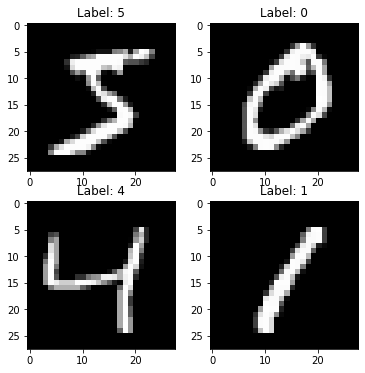

In [6]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]    
    
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])    
        
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True) ## Let's look at some example

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray')

In [7]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    # assert len(activations) == len(network)
    return activations

def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability    
    logits = forward(network,X)[-1]
    print(logits)
    return logits.argmax(axis=-1)

def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9809


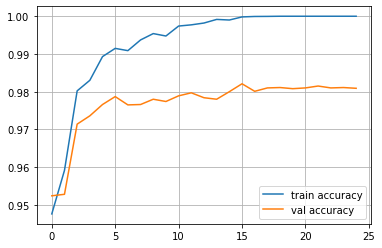

In [8]:
from tqdm import trange

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    # assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        
from IPython.display import clear_output
train_log = []
val_log = []

for epoch in range(25):    
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [9]:
import matplotlib.pyplot as plt
import scipy.sparse
import pandas as pd
import numpy as np
import string
import re

from typing import Tuple
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
train_data = pd.read_csv('train.csv', names=['target', 'text', 'description'])
test_data = pd.read_csv('test.csv', names=['target', 'text', 'description'])

train_data.head()

,target,text,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [11]:
def preprocess(data: pd.Series) -> pd.Series:
    """ Performs the following actions:
            1. Removes all punctionation
            2. Removes stop words and common words
            3. Removes symbols
            4. Removes URLs
            5. Remove numbers
    """
    text = data
    text = _remove_url(text)
    text = _remove_non_chars(text)
    text = _remove_stopwords(text)
    return text
    
def _remove_url(column: pd.Series) -> pd.Series:
    """ Removes all URLs from the data """
    url_match = re.compile("https?:\/\/\S+")
    return column.apply(lambda x: re.sub(url_match, " ", x))
    
def _remove_non_chars(column: pd.Series) -> pd.Series:
    """ Removes all non-characters from the string, including punctionation and numbers """
    char_match = re.compile("[^a-z\s\']+")
    return column.apply(lambda x: re.sub(char_match, " ", x.lower()).replace("'", ""))

def _remove_stopwords(column: pd.Series) -> pd.Series:
    """ Removes stopwords """
    words = set(stopwords.words('english'))    
    return column.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in words]))

In [12]:
train_data['text'] = preprocess(train_data['text'])
test_data['text'] = preprocess(test_data['text'])

In [18]:
def get_top_per_class(data: pd.DataFrame, group: str, col: str, per: int = 2000) -> set:
    """ Gets the top per words from each class and returns the total vocab, in no particular order """
    vocab = set()
    for group, frame in data.groupby(group):
        class_vocab = []
        [class_vocab.extend(word_tokenize(x)) for x in frame[col]]
        freq = FreqDist(class_vocab)
        vocab.update(sorted(freq, key=freq.get, reverse=True)[:per])
    return vocab

In [19]:
top = get_top_per_class(train_data, 'target', 'text', per=1500)

In [20]:
vectorizer = TfidfVectorizer(vocabulary=top)
x_train = vectorizer.fit_transform(train_data['text'])
y_train = np.array(train_data['target'])
x_train = x_train.todense()

x_test = vectorizer.transform(test_data['text']).todense()
y_test = np.array(test_data['target'])


x_train.shape, y_train.shape, x_test.shape, y_test.shape

((120000, 3676), (120000,), (7600, 3676), (7600,))

In [23]:
network = []
network.append(Dense(x_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,4))

In [31]:
from IPython.display import clear_output
train_log = []
val_log = []

for epoch in range(25):    
    for x_batch,y_batch in iterate_minibatches(x_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

  0%|          | 0/3750 [00:00<?, ?it/s]

[[ 0.00951016  0.00056882 -0.00181999  0.00124075]
 [-0.01549204 -0.00675857  0.0265039  -0.00411326]
 [-0.01318411 -0.00358667  0.02498792 -0.00326046]
 [-0.01984185 -0.02294974  0.00947592  0.00585662]
 [-0.00116343 -0.02704053  0.01319017  0.00157841]
 [-0.01829318 -0.01225317  0.02532035 -0.00125747]
 [-0.01422077 -0.00826436  0.02567676 -0.01046268]
 [-0.0049916  -0.00998407  0.00397623 -0.00141518]
 [-0.01112056 -0.01827213  0.02333352  0.0063632 ]
 [-0.01379234 -0.01249197  0.00969662 -0.0018329 ]
 [-0.02382547 -0.00763707  0.01926259  0.005694  ]
 [ 0.          0.          0.          0.        ]
 [-0.00444565 -0.03622775  0.01527456 -0.00799904]
 [-0.01759285 -0.00739639  0.01663422  0.00759231]
 [-0.03221322 -0.01428158  0.01920571 -0.00290632]
 [-0.01493673 -0.0087356   0.00056006  0.00733657]
 [-0.01780269 -0.01136523  0.02496816 -0.00855702]
 [-0.0196047   0.0001311   0.03151615  0.00803351]
 [-0.02306371 -0.00271843  0.01634114 -0.02356117]
 [-0.0098001  -0.00282879  0.01

IndexError: index 4 is out of bounds for axis 1 with size 4

In [33]:
answers = [3, 2, 1, 4, 1, 4, 3, 2, 2, 4, 1, 3, 1, 4, 1, 3, 3, 4, 2, 2, 4, 4, 4, 4, 3, 2, 2, 2, 4, 2, 4, 3]
logits = np.random.normal(scale=0.01, size=(32, 4))
logits[np.arange(4), answers]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (4,) (32,) 